# 1. Data Preprocessing

## 1.1. Mounting Drive

In [1]:
# from google.colab import drive
import os
# drive.mount('/content/drive')

# #adjust path with the dataset in google drive
# drive_data_path = '/content/drive/MyDrive/capstone/dataset/dataset'

# os.listdir(drive_data_path)

## 1.2. Parameters

In [2]:
#Specifying some parameters
class Config:
  class_names = ['5000', '10000', '50000'],
  num_classes = 3,
  img_height = 224,
  img_width  = 224,
  labels = "inferred",
  label_mode = "int",
  color_mode = "rgb",
  batch_size = 32,
  # dir_type = ['training', 'development','validation']
  dir_type = ['training','validation']

## 1.3. Declaring Source Directory Path

In [3]:
#creating a dictionary consist of source directory's path
def creating_source_path(dir_base):
  source_dir = {}

  for names in Config.class_names[0]:
    source_dir['dir_' + names] = os.path.join(dir_base, names)

  return  source_dir

In [4]:
#dataset source path
dir_base = 'dataset\\dataset'

source_dir =  creating_source_path(dir_base)

print(source_dir)

{'dir_5000': 'dataset\\dataset\\5000', 'dir_10000': 'dataset\\dataset\\10000', 'dir_50000': 'dataset\\dataset\\50000'}


In [5]:
#checking dataset

def check_source_dir(source_dir):
  for key, value in source_dir.items():
    print(f'total {key} rupiah images: ', len(os.listdir(value)))

check_source_dir(source_dir)

total dir_5000 rupiah images:  691
total dir_10000 rupiah images:  637
total dir_50000 rupiah images:  582


In [12]:
for value in source_dir.values():
    print(value)

dataset\dataset\5000
dataset\dataset\10000
dataset\dataset\50000


In [17]:
# import shutil

# def create_dirs(root_path):
#   path_dir = {}
#   for names in Config.class_names[0]:
#     path_dir['dataset_' + names] = os.path.join('working_dataset', names)
  

#   #delete existing directory
#   for path in path_dir.values():
#     if os.path.exists(path):
#       shutil.rmtree(path)
#       print(f"The directory {path} has been deleted.")
#     else:
#         print(f"The directory {path} does not exist.")  

#   for path in path_dir.values():
#     try:
#       os.makedirs(path)
#       print(path, 'created')
#     except:
#       print(path, 'failed')
#   pass

# creating_dir = ""

dataset = 'working_dataset'

# try:
#   create_dirs(root_path=creating_dir)
# except FileExistsError:
#   print("You should not be seeing this since the upper directory is removed beforehand")

## 1.4. Load Dataset with ImageDataGenerator

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                               brightness_range = (0.5, 1.5),
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = True,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               rotation_range = 20,
                               validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)



train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training')

valid_generator = valid_datagen.flow_from_directory(
    dataset,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation')


Found 2015 images belonging to 3 classes.
Found 502 images belonging to 3 classes.


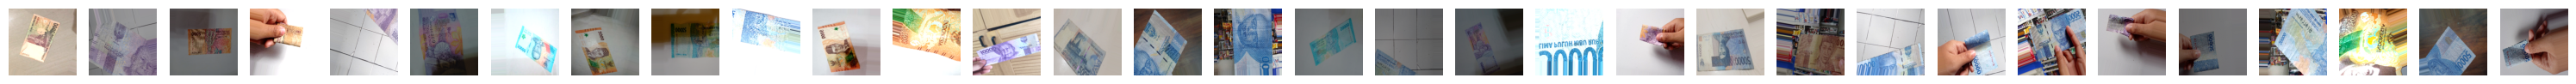

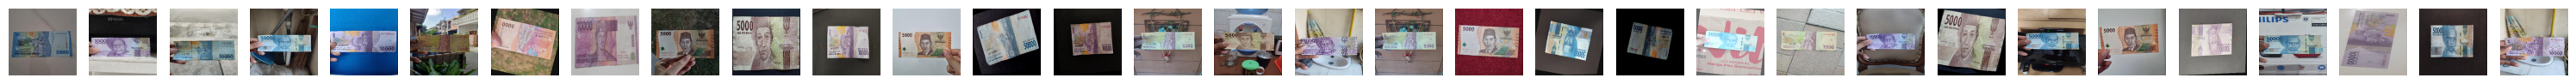

In [19]:
#Checking Loaded Image After Augmentation

import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load one batch of training data
train_images, train_labels = next(train_generator)

# Plot the training images
plot_images(train_images)

# Load one batch of validation data
val_images, val_labels = next(valid_generator)

# Plot the validation images
plot_images(val_images)

In [20]:
images, labels = next(train_generator)

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 224, 224, 3)
float32 (32,)


In [9]:
# #Transform it to Dataset type

# train_ds = tf.data.Dataset.from_generator(
#     lambda: train_datagen.flow_from_directory(
#         dir_base,
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode='categorical',
#         subset='training'
#         ),
#     output_signature=(
#       tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
#       tf.TensorSpec(shape=(32, 7), dtype=tf.float32, name=None)
#    )
# )

# valid_ds = tf.data.Dataset.from_generator(
#     lambda: valid_datagen.flow_from_directory(
#         dir_base,
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode='categorical',
#         subset='validation'
#         ),
#     output_signature=(
#       tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None),
#       tf.TensorSpec(shape=(32, 7), dtype=tf.float32, name=None)
#    )
# )



In [10]:
# #for prefetching and caching performance purpose
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_generator.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = valid_generator.cache().prefetch(buffer_size=AUTOTUNE)


# 2. Creating Model

In [11]:
#creating checkpoints and earlystopping

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_filepath = 'checkpoint\\model-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                              monitor='val_accuracy',
                              mode='max',
                              save_best_only=True,
                              verbose=1
                             )

callbacks = EarlyStopping(monitor = 'loss', patience = 3, verbose = 1)

## 2.1. CNN Model

In [12]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, GlobalMaxPooling2D, Dropout, AveragePooling2D


model = Sequential([
    Input(shape = (Config.img_height[0], Config.img_width[0], 3)),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(7)


])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 111, 111, 128)  │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 26, 26, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,865,767 (10.93 MB)

 Trainable params: 2,865,767 (10.93 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [15]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [16]:
model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[callbacks, checkpoint]
)

Epoch 1/20


C:\Users\OMEN\AppData\Local\Programs\Python\Python310\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2154 - loss: 1.9333
Epoch 1: val_accuracy improved from -inf to 0.26800, saving model to checkpoint\model-01-0.2680.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.2156 - loss: 1.9322 - val_accuracy: 0.2680 - val_loss: 1.6627
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3497 - loss: 1.6530
Epoch 2: val_accuracy did not improve from 0.26800
107/107 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.3498 - loss: 1.6533 - val_accuracy: 0.2243 - val_loss: 1.7946
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3190 - loss: 1.7011
Epoch 3: val_accuracy did not improve from 0.26800
107/107 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.3192 - loss: 1.7007 - val_accuracy: 0.2680 - val_loss: 1.7136
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4719 - loss: 1.3931
Epoch 4: val_accuracy improved from 0.26800 to 0.54545, saving model to checkpoint\model-04-0.5455.keras
107/107 

KeyboardInterrupt: 

In [ ]:
model.save('model.keras')

## 2.2. Transfer Learning

In [ ]:
from keras.applications.